In [1]:
import cobra

In [2]:
import cplex

In [3]:
from cobra import Model, Reaction, Metabolite
from cobra.test import create_test_model

In [4]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
yali = cobra.io.read_sbml_model('iyali.xml')

In [6]:
yali.medium

{'y001654': 1000.0,
 'y001714': 1.0,
 'y001832': 1000.0,
 'y001861': 1000.0,
 'y001992': 1000.0,
 'y002005': 1000.0,
 'y002020': 1000.0,
 'y002049': 1000.0,
 'y002060': 1000.0,
 'y002100': 1000.0}

In [23]:
yali.exchanges

[<Reaction y001542 at 0x7fc6003e6d90>,
 <Reaction y001545 at 0x7fc6003e6dc0>,
 <Reaction y001546 at 0x7fc6003d9a60>,
 <Reaction y001547 at 0x7fc6003e6a60>,
 <Reaction y001548 at 0x7fc6003e6520>,
 <Reaction y001550 at 0x7fc6003f28b0>,
 <Reaction y001551 at 0x7fc6003f2970>,
 <Reaction y001552 at 0x7fc6003f2a30>,
 <Reaction y001553 at 0x7fc6003f2af0>,
 <Reaction y001554 at 0x7fc6003f2bb0>,
 <Reaction y001566 at 0x7fc6003f2eb0>,
 <Reaction y001572 at 0x7fc6003f2e20>,
 <Reaction y001577 at 0x7fc600385610>,
 <Reaction y001580 at 0x7fc6003858b0>,
 <Reaction y001586 at 0x7fc600385c40>,
 <Reaction y001589 at 0x7fc600385ee0>,
 <Reaction y001598 at 0x7fc600385490>,
 <Reaction y001604 at 0x7fc600392730>,
 <Reaction y001621 at 0x7fc600392f70>,
 <Reaction y001625 at 0x7fc60042cbb0>,
 <Reaction y001627 at 0x7fc600392e50>,
 <Reaction y001629 at 0x7fc600392f40>,
 <Reaction y001630 at 0x7fc600392eb0>,
 <Reaction y001631 at 0x7fc6003a25b0>,
 <Reaction y001634 at 0x7fc6003a28b0>,
 <Reaction y001639 at 0x7

In [24]:
yali.reactions.xBIOMASS

Reaction identifier,xBIOMASS
Name,Biomass production
Memory address,0x07fc6009fc970
Stoichiometry,m1726 + m1727 + 0.4415 s_0002 + 0.0757 s_0423 + 86.7881 s_0434 + 0.4068 s_0509 + 0.0578 s_0526 + 0.0383 s_0584 + 0.0377 s_0589 + 0.0377 s_0615 + 0.0383 s_0649 + 0.093 s_0782 + 0.1104 s_1107 +... protein + lipids + 0.4415 (1-3)-beta-D-glucan + 0.0757 AMP + 86.7881 ATP + 0.4068 chitin + 0.0578 CMP + 0.0383 dAMP + 0.0377 dCMP + 0.0377 dGMP + 0.0383 dTMP + 0.093 GMP + 0.1104 mannan + 0.0032...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [25]:
yali.metabolites.s_0565

Metabolite identifier,s_0565
Name,D-glucose
Memory address,0x07fc600aa73d0
Formula,C6H12O6
Compartment,e
In 4 reaction(s),"y000370, y001024, y001166, y001714"


In [26]:
yali.reactions.y001024

Reaction identifier,y001024
Name,sucrose hydrolyzing enxyme
Memory address,0x07fc600564ca0
Stoichiometry,s_0805 + s_1466 --> s_0554 + s_0565 H2O + sucrose --> D-fructose + D-glucose
GPR,YALI0E26719g
Lower bound,0.0
Upper bound,1000.0


In [27]:
yali.reactions.y001714

Reaction identifier,y001714
Name,D-glucose exchange
Memory address,0x07fc60034eee0
Stoichiometry,s_0565 <-- D-glucose <--
GPR,
Lower bound,-1.0
Upper bound,-1.0


In [16]:
yali.reactions.y001714.lower_bound = -10
yali.reactions.y001714.upper_bound = 0

In [17]:
yali.reactions.y001714

Reaction identifier,y001714
Name,D-glucose exchange
Memory address,0x02d922aceeb0
Stoichiometry,s_0565 <-- D-glucose <--
GPR,
Lower bound,-10
Upper bound,0


In [44]:
yali.metabolites.s_0523

Metabolite identifier,s_0523
Name,citrate
Memory address,0x07fc600a13640
Formula,C6H5O7
Compartment,e
In 2 reaction(s),"y001687, y001686"


In [45]:
yali.reactions.y001687

Reaction identifier,y001687
Name,citrate(3-) exchange
Memory address,0x07fc60033f520
Stoichiometry,s_0523 --> citrate -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [7]:
def add_dynamic_bounds(yali, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose, citrate = y  # expand the boundary species
    #glucose_max_import = -10 * glucose / (5 + glucose)
    #yali.reactions.y001714.lower_bound = glucose_max_import
    #yali.reactions.y001687.lower_bound =  5 *citrate / (2 + citrate)

def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose, citrate = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with yali:
        add_dynamic_bounds(yali, y)

        cobra.util.add_lp_feasibility(yali)
        feasibility = cobra.util.fix_objective_as_constraint(yali)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            yali, ['xBIOMASS', 'y001714',  'y001687'], ['max', 'max','max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with yali:

        add_dynamic_bounds(yali, y)

        cobra.util.add_lp_feasibility(yali)
        feasibility = cobra.util.fix_objective_as_constraint(yali)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [8]:
ts = np.linspace(0, 10, 5)  # Desired integration resolution and interval
y0 = [0.1, 10, 0]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 10.000: : 52it [05:47,  6.69s/it]


In [9]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 46
     njev: 1
      nlu: 8
      sol: None
   status: 0
  success: True
        t: array([ 0. ,  2.5,  5. ,  7.5, 10. ])
 t_events: [array([], dtype=float64)]
        y: array([[ 0.1       ,  0.13024296,  0.16963221,  0.22093387,  0.2877507 ],
       [10.        ,  9.71385665,  9.34117578,  8.85578588,  8.22359941],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])
 y_events: [array([], dtype=float64)]

Text(0, 0.5, 'Citrato1')

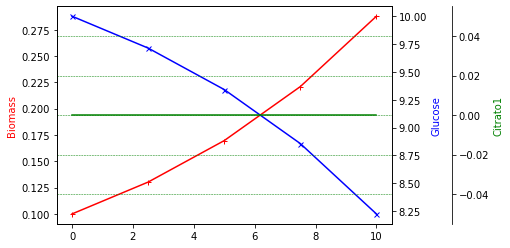

In [10]:
fig, ax1 = plt.subplots()

ax1.plot(sol.t, sol.y.T[:, 0], color='r', marker='+', markersize=5)
ax2 = plt.twinx(ax1)
ax2.plot(sol.t, sol.y.T[:, 1], color='b', marker='x', markersize=5)

ax3 = ax1.twinx()
ax3.plot(sol.t, sol.y.T[:, 2],color="green")
ax3.spines['right'].set_position(('outward',60))

#ax4 = ax1.twinx()
#ax4.plot(sol.t, sol.y.T[:, 3],color="yellow")
#ax4.spines['right'].set_position(('outward',120))

plt.grid(axis = 'both', color = 'green', linestyle = '--', linewidth = 0.5)

ax1.set_ylabel('Biomass', color='r')
ax2.set_ylabel('Glucose', color='b')
ax3.set_ylabel('Citrato1', color='g')
#ax4.set_ylabel('Citrato2', color='y')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [14]:
def heatmap_flux(minimal_flux=0.05,save=False,**kwargs):
    #"""
    #Fonction qui plot un heat map en utilisant Seaborn
    #la fonction prend n'importe quel nombre d'objet solutions produit par run_model_calpainopathie() ou define_boundary_and_run_model()
    #"""
    list_df=list()
    for solution in kwargs["solutions"] :
        series=solution.fluxes[solution.fluxes!=0] #remove 0 values
        df=series.to_frame()
        df["name"]=df.index
        df = df.drop(df[df.fluxes < minimal_flux].index) #enlève les flux avec une valeur inférieur a minimal_flux
        list_df.append(df)
    #Quadraboucle qui s'assure que chaque DF contient les mêmes labels (que toutes les réactions soient présente dans chaque DF)
    #si ce n'est pas le cas rajoute une ligne avec pour valeur 0 dans les dataframe qui n'ont pas le label (Nom de réaction)
    for df in list_df :
        for i in df.index :
            for df2 in list_df :
                if i not in df2.index :
                    df2.loc[i]=[0,i]
    # combine tous les DF dans un seul DF nommé results
    results=pd.DataFrame()
    compteur=0
    for name in kwargs["name_columns"] :
        results[name]=list_df[compteur]["fluxes"]
        compteur+=1

    #plot 
    fig, ax = plt.subplots(figsize=(20,50))
    ax=sns.heatmap(results)
    #savefig
    if save==True :
        fig = ax.get_figure()
        fig.savefig(kwargs["name_plot"]) 
    return results

In [15]:
heatmap_flux()

KeyError: 'sol'